# Datos barrios Capital Federal y Geopandas

---

<a id="toc"></a> 
## Tabla de Contenidos

[Resumen](#section_resumen)

[Imports](#imports)

[Dataset y máscara](#section_dataset_y_máscara)

[Diccionario](#diccionario)

[Valores incompletos](#incompletos)

[Geodatos CABA](#geo_caba)

[Unificar](#unificar)

[Recategorizar nuevos barrios](#recategorizar)

[Verificación](#verificacion)

[Columna "geometry"](#geometry)

[Exportación de la base](#exportacion)

<a id="section_resumen"></a> 
## Resumen

[volver a TOC](#toc)

El Data Frame original de Properatti cuenta con aproximadamente 32 mil valores dentro de la Capital Federal. 
La columna "place_name" muestra los barrios de las propiedades. Para los valores de CABA, decidimos ordenar esa columna.

1.297 valores no especificaban a cuál barrio de la Ciudad pertenecían. La mitad de esta cifra, contaba con geo datos.
Con esa información, conseguimos identificar el barrio de más de 600 propiedades.

Por otro lado, ajustamos las categorías de la columna "place_name" de manera coincidente con los 48 barrios reconocidos \
por la Ciudad de Buenos Aires. De este modo, será más sencillo cruzar la base con datos externos de la Ciudad.

Finalmente, generamos la columna "geometry" conteniendo todos los puntos de las propiedades que poseen geodatos, permitiéndonos ubicarlos en el mapa.

---

<a id="imports"></a> 
## Imports 

[volver a TOC](#toc)

In [3]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import pyproj

---

<a id="section_dataset_y_máscara"></a> 
## Dataset y máscara

[volver a TOC](#toc)



Importo los datos de Properatti e importo una base de CABA para extraer los nombres de los barrios oficiales.

In [4]:
location = "../Desafío 1/properatti.csv"
data = pd.read_csv(location)

location_delitos = "../Desafío 1/caba_delitos_2019.csv"
data_delitos = pd.read_csv(location_delitos, low_memory = False)

Chequeo ambas bases

In [5]:
data.head(2)

,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.0,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
1,1,sell,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Argentina,Bs.As. G.B.A. Zona Sur,3432039.0,"-34.9038831,-57.9643295",-34.903883,...,NaN,NaN,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15bob_venta_depart...,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,https://thumbs4.properati.com/7/ikpVBu2ztHA7jv...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121220 entries, 0 to 121219
Data columns (total 26 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  121220 non-null  int64  
 1   operation                   121220 non-null  object 
 2   property_type               121220 non-null  object 
 3   place_name                  121197 non-null  object 
 4   place_with_parent_names     121220 non-null  object 
 5   country_name                121220 non-null  object 
 6   state_name                  121220 non-null  object 
 7   geonames_id                 102503 non-null  float64
 8   lat-lon                     69670 non-null   object 
 9   lat                         69670 non-null   float64
 10  lon                         69670 non-null   float64
 11  price                       100810 non-null  float64
 12  currency                    100809 non-null  object 
 13  price_aprox_lo

In [7]:
data_delitos.head(2)

,id,fecha,franja_horaria,tipo_delito,subtipo_delito,cantidad_registrada,comuna,barrio,lat,long
0,1038983,13-09-19,14,Robo (con violencia),NaN,NaN,6.0,Caballito,-34.609876,-58.456159
1,1038986,13-09-19,16,Robo (con violencia),NaN,NaN,3.0,Balvanera,-34.609394,-58.395934


In [8]:
data_delitos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122484 entries, 0 to 122483
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   122484 non-null  int64  
 1   fecha                122484 non-null  object 
 2   franja_horaria       122484 non-null  object 
 3   tipo_delito          122484 non-null  object 
 4   subtipo_delito       6275 non-null    object 
 5   cantidad_registrada  10304 non-null   float64
 6   comuna               121792 non-null  float64
 7   barrio               121792 non-null  object 
 8   lat                  121792 non-null  float64
 9   long                 121792 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 9.3+ MB


Selecciono la información que necesito de cada Data Set.
Primero guardo las propiedades que se encuentran en CABA.

In [9]:
data_caba_mask = data.state_name == "Capital Federal"
data_caba = data[data_caba_mask]
data_caba.place_name.value_counts()

Belgrano           2992
Palermo            2885
Caballito          2273
Villa Urquiza      1629
Recoleta           1547
                   ... 
Velez Sarsfield      39
Villa Real           37
Villa Soldati        15
Villa Riachuelo       6
Catalinas             4
Name: place_name, Length: 62, dtype: int64

In [10]:
barrios_caba = data_caba.place_name.unique()
barrios_caba.shape

(62,)

Después, extraigo los nombres de los barrios según el DF de la Ciudad de Buenos Aires.

In [11]:
barrios_delitos = data_delitos.barrio.unique()
print(barrios_delitos.shape)
print(barrios_delitos)

(49,)
['Caballito' 'Balvanera' 'Monserrat' 'Villa Gral. Mitre' 'Villa Crespo'
 'Villa Devoto' 'Almagro' 'Paternal' 'Villa del Parque' 'Recoleta'
 'Chacarita' 'Palermo' 'Retiro' 'San Nicolás' 'Villa Ortuzar' 'Colegiales'
 'Villa Urquiza' 'Belgrano' 'Nuñez' 'Saavedra' 'Villa Lugano'
 'Villa Soldati' 'Parque Avellaneda' 'Barracas' 'Mataderos'
 'Nueva Pompeya' 'Flores' 'Parque Patricios' 'Boca' 'Parque Chacabuco'
 'Liniers' 'Boedo' 'Floresta' 'Vélez Sársfield' 'Monte Castro' 'San Telmo'
 'Villa Santa Rita' 'San Cristóbal' 'Parque Chas' 'Villa Riachuelo'
 'Villa Luro' 'Villa Pueyrredón' 'Coghlan' 'Villa Real' 'Versalles'
 'Puerto Madero' nan 'Constitución' 'Agronomía']


<a id="diccionario"></a> 
## Diccionario

[volver a TOC](#toc)

Determino cuáles serán los barrios para las propiedades en CABA, tomando por referencia los nombres utilizados por las \
bases del Gobierno de la Ciudad.

Primero armo un Frame con las categorías de Properatti y la Ciudad, y vemos la cantidad de barrios únicos.

In [147]:
todos_barrios_lista = barrios_caba.tolist() + barrios_delitos.tolist()
df_todos_barrios = pd.DataFrame(todos_barrios_lista)
df_todos_barrios.value_counts()

Parque Avellaneda    2
Mataderos            2
Villa Pueyrredón     2
Nuñez                2
Villa Ortuzar        2
                    ..
Palermo Soho         1
Palermo Viejo        1
Parque Centenario    1
Pompeya              1
Vélez Sársfield      1
Length: 66, dtype: int64

Luego elimino los duplicados.

In [13]:
def no_duplicados (data_uno, data_dos):
    result = []
    for x in data_uno:
        if x not in data_dos:
            result += [x]
    return(result)

In [14]:
barrios_extra = no_duplicados(barrios_caba, barrios_delitos)
barrios_extra.sort()
print(barrios_extra)

['Abasto', 'Barrio Norte', 'Capital Federal', 'Catalinas', 'Centro / Microcentro', 'Congreso', 'Las Cañitas', 'Once', 'Palermo Chico', 'Palermo Hollywood', 'Palermo Soho', 'Palermo Viejo', 'Parque Centenario', 'Pompeya', 'San Cristobal', 'Tribunales', 'Velez Sarsfield', 'Villa General Mitre']


Cotenjando los valores "sobrantes" con los 48 barrios que esperamos tener, armamos un diccionario.

In [15]:

diccionario = {"Catalinas": "Retiro", "Congreso":"Balvanera", "Las Cañitas": "Palermo", "Once":"Balvanera",\
               "Palermo Chico":"Palermo","Palermo Hollywood": "Palermo", "Palermo Soho":"Palermo", "Palermo Viejo":"Palermo",\
               "Parque Centenario":"Caballito", "Pompeya":"Nueva Pompeya", "San Cristobal":"San Cristóbal",\
               "Tribunales": "San Nicolás", "Velez Sarsfield":"Vélez Sársfield", "Villa General Mitre":"Villa Gral. Mitre",\
              "Abasto": "Balvanera", "Barrio Norte":"Recoleta", "Centro / Microcentro":"San Nicolás",\
               "Constitucion":"Constitución", "San Nicolas":"San Nicolás", "Villa Pueyrredon":"Villa Pueyrredón",\
              "Nan":np.NaN}

Aplico mi diccionario sobre "place_name" de CABA, generando una nueva columna, "new_place". Los datos que no encuentre en \
el diccionario, van a figurar con su categoría original de "place_name". Esto la hacemos aplicando el método .map y lambda.

In [16]:
data_dos = data
data_dos["new_place"] = data_dos.place_name.map(lambda x: diccionario[x] if x in diccionario.keys() else x)

In [17]:
mask_dos = data_dos.state_name == "Capital Federal"
data_caba = data_dos[mask_dos]
data_caba.new_place.value_counts(dropna= False)

Palermo              4226
Belgrano             2992
Recoleta             2687
Caballito            2341
Villa Urquiza        1629
Flores               1354
Villa Crespo         1331
Capital Federal      1297
Balvanera            1282
San Telmo            1216
Almagro              1165
Boedo                 890
Nuñez                 778
Puerto Madero         647
San Cristóbal         614
Saavedra              542
Monserrat             538
Floresta              516
San Nicolás           508
Villa del Parque      488
Villa Luro            432
Barracas              425
Villa Devoto          420
Mataderos             418
Liniers               408
Colegiales            352
Parque Patricios      322
Coghlan               259
Retiro                252
Chacarita             227
Boca                  223
Constitución          211
Villa Lugano          205
Villa Pueyrredón      175
Paternal              173
Parque Chacabuco      146
Villa Ortuzar          86
Monte Castro           79
Nueva Pompey

Podemos ver algunos ejemplos de barrios que cambiaron de nombre.

In [18]:
data_dos[mask_dos][["place_name", "new_place"]].sample(5)

,place_name,new_place
116946,Once,Balvanera
84887,Almagro,Almagro
25626,Boedo,Boedo
1396,Almagro,Almagro
62543,Caballito,Caballito


<a id="incompletos"></a> 
## Valores incompletos

[volver a TOC](#toc)

Podemos ver que no todos los datos de "new_place" contienen un barrio. Tenemos 1.297 valores con la etiqueta \
"Capital Federal". Podemos encontrar el barrio de pertenencia de estas propiedades utilizando Geopandas, siempre\
y cuando tengamos su geolocalización.

Veamos cuántos valores georreferenciados tenemos. 

In [19]:
sin_barrio_mask1 = data_dos.new_place == "Capital Federal"
sin_barrio_mask2 = data_dos.lat.notnull() == True
sin_barrio_mask = sin_barrio_mask1 & sin_barrio_mask2
caba_sin_barrio = data_dos[sin_barrio_mask]
caba_sin_barrio.shape

(602, 27)

Encontramos que 602 de los 1.297 valores sin barrio de CABA, tienen Geodatos. Los valores restantes, al final figurarán\
como "NaN".

<a id="geo_caba"></a> 
## Geodatos CABA

[volver a TOC](#toc)

Vamos a usar los polígonos de los 48 barrios de CABA para ver a donde pertenecen, extrayendo el nombre del polígono \
correspondiente para asignarle una categoría a cada punto.

Primero importamos los polígonos.

In [20]:
pol_barrios = gpd.read_file("../Data/barrios.csv", encoding='latin1')

Ahora transformamos la latitud y longitud de nuestro Data Frame "caba_sin_barrio" en puntos localizables.

In [21]:
geometria_sin_barrio = gpd.points_from_xy(caba_sin_barrio.lon, caba_sin_barrio.lat)
geo_sin_barrio = gpd.GeoDataFrame(caba_sin_barrio, geometry = geometria_sin_barrio)
geo_sin_barrio.geometry.head()

901     POINT (-58.41171 -34.61086)
1081    POINT (-58.46600 -34.54790)
1498    POINT (-58.38592 -34.61445)
1499    POINT (-58.38592 -34.61445)
2844    POINT (-58.36832 -34.60277)
Name: geometry, dtype: geometry

Podemos visualizar la distribución de los puntos sobre el mapa de la Ciudad de Buenos Aires.

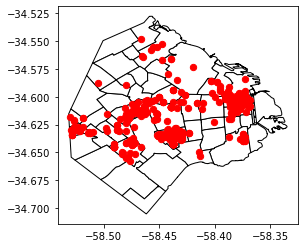

In [22]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
pol_barrios.plot(ax=ax, color='white', edgecolor='black')
geo_sin_barrio.plot(ax=ax, marker='o', color='red', markersize=40)
plt.show();

El siguiente paso es buscar a qué barrio pertenece cada punto, según su ubicación en los polígonos de la Ciudad. \
Vamos a guardar las nuevas etiquetas en una columna llamada "Nueva columna".

In [23]:
geo_sin_barrio["new_place"] = geo_sin_barrio.geometry.apply(lambda x: pol_barrios[pol_barrios.contains(x)]["BARRIO"].iloc[0])
geo_sin_barrio.new_place.value_counts(dropna = False)

PARQUE CHACABUCO     297
SAN NICOLAS           76
CABALLITO             33
PARQUE AVELLANEDA     26
VERSALLES             24
VILLA GRAL. MITRE     18
VILLA SANTA RITA      16
MONSERRAT             13
VILLA CRESPO          13
RECOLETA              11
RETIRO                11
BARRACAS               8
ALMAGRO                6
BELGRANO               6
FLORESTA               5
PALERMO                5
VELEZ SARSFIELD        5
BALVANERA              4
FLORES                 4
VILLA REAL             3
VILLA LURO             3
NUEVA POMPEYA          2
VILLA DEVOTO           2
BOEDO                  2
CONSTITUCION           2
PARQUE CHAS            1
SAN CRISTOBAL          1
NUÑEZ                  1
VILLA PUEYRREDON       1
MONTE CASTRO           1
COLEGIALES             1
PATERNAL               1
Name: new_place, dtype: int64

Antes de agregar estos datos a nuestro DF general, lo convertimos de GeoDataFrame a DataFrame.

In [24]:
barrios_nuevos = pd.DataFrame(geo_sin_barrio)
type(barrios_nuevos)

pandas.core.frame.DataFrame

<a id="unificar"></a> 
## Unificar

[volver a TOC](#toc)

Ya contamos con 602 nuevas propiedades con su barrio identificado. Notamos que los nombres, a diferencia de nuestro\
diccionario, se encuentran en mayúscula. El siguiente paso es unir estos datos a nuestra base original, y estandarizar las\
categorías de los barrios.

Primero vamos a reemplazar en la base nuestros nuevos datos. Para eso vamos a eliminar la columna "geometry" de "barrios\
nuevos". De esta forma nos coinciden las columnas en ambos DF.

In [32]:
barrios_nuevos = barrios_nuevos.drop(columns = "geometry")

In [33]:
barrios_nuevos.shape

(602, 27)

In [34]:
data_dos.shape

(121220, 27)

Tenemos 27 columnas en ambos DF. Primero vamos a reemplazar en "new_place" la categoría "Capital Federal" por NaN.\
De este modo, los valores que no hayamos definido por su localización quedarán como vacíos.

In [36]:
data_dos = data_dos.replace({"new_place":{"Capital Federal": np.NaN}})
data_dos.new_place.isnull().sum()

1320

Ahora unimos los dos frames, poniendo primero el que contiene los 602 valores nuevos. Quitamos los duplicados en\
base a los índices, y conservamos el primer valor encontrado. El DF resultante debe tener 121.220 filas. 

In [40]:
frames = [barrios_nuevos, data_dos]
result = pd.concat(frames)
result.shape

(121822, 27)

In [41]:
new_frame = result.drop_duplicates(subset = ["Unnamed: 0"], keep="first")
new_frame.shape

(121220, 27)

Ordenamos las filas en base a su índice, y chequeamos cuántas categorías tenemos en "new_place".

In [46]:
new_frame = new_frame.sort_values(by = "Unnamed: 0")
new_frame.shape

(121220, 27)

In [48]:
new_frame[data_caba_mask]["new_place"].value_counts()

Palermo          4226
Belgrano         2992
Recoleta         2687
Caballito        2341
Villa Urquiza    1629
                 ... 
COLEGIALES          1
PATERNAL            1
PARQUE CHAS         1
MONTE CASTRO        1
SAN CRISTOBAL       1
Name: new_place, Length: 80, dtype: int64

In [51]:
new_frame[data_caba_mask]["new_place"].unique().shape

(81,)

<a id="recategorizar"></a> 
## Recategorizar nuevos barrios

[volver a TOC](#toc)

Como vemos en el paso anterior, tenemos 81 categorías en "new_place". Para poder llegar a contar con 49 valores posibles\
en esta columna tomando las propiedades de CABA, tenemos que pasar recategorizar los nuevos barrios.

Los nuevos barrios se encuentran en mayúscula. Para estandarizar, pasamos la columns "new_place" a string y dejemos la\
primera letra de cada palabra en mayúscula.

In [61]:
frame_recat = new_frame

In [63]:
frame_recat["new_place"] = frame_recat.new_place.map(lambda x: str(x))
frame_recat.new_place

0             Mataderos
1              La Plata
2             Mataderos
3               Liniers
4                Centro
              ...      
121215         Belgrano
121216           Beccar
121217    Villa Urquiza
121218      Plaza Colón
121219              nan
Name: new_place, Length: 121220, dtype: object

In [77]:
frame_recat["new_place"] = frame_recat.new_place.map(lambda x: x.title())
frame_recat[data_caba_mask]["new_place"].unique().shape

(54,)

Nos quedamos con 54 valores. Vamos a ver qué barrios nos sobran.

In [88]:
lista_recat = frame_recat[data_caba_mask]["new_place"].unique().tolist()
lista_delitos = data_delitos.barrio.unique().tolist()

In [94]:
lista_delitos

['Almagro',
 'Balvanera',
 'Barracas',
 'Belgrano',
 'Boca',
 'Boedo',
 'Caballito',
 'Chacarita',
 'Coghlan',
 'Colegiales',
 'Flores',
 'Floresta',
 'Liniers',
 'Mataderos',
 'Monserrat',
 'Monte Castro',
 'Nueva Pompeya',
 'Nuñez',
 'Palermo',
 'Parque Avellaneda',
 'Parque Chacabuco',
 'Parque Chas',
 'Parque Patricios',
 'Paternal',
 'Puerto Madero',
 'Recoleta',
 'Retiro',
 'Saavedra',
 'San Cristóbal',
 'San Nicolás',
 'San Telmo',
 'Versalles',
 'Villa Crespo',
 'Villa Devoto',
 'Villa Gral. Mitre',
 'Villa Lugano',
 'Villa Luro',
 'Villa Ortuzar',
 'Villa Pueyrredón',
 'Villa Real',
 'Villa Riachuelo',
 'Villa Santa Rita',
 'Villa Soldati',
 'Villa Urquiza',
 'Villa del Parque',
 'Vélez Sársfield',
 nan,
 'Constitución',
 'Agronomía']

In [87]:
barrios_extra_dos = no_duplicados(lista_recat, lista_delitos)
barrios_extra_dos

['Nan',
 'Villa Del Parque',
 'San Nicolas',
 'Velez Sarsfield',
 'Constitucion',
 'San Cristobal',
 'Villa Pueyrredon']

Modifico mi diccionario, contemplando las nuevas diferencias. Lo aplico a la columna "new_place" de "frame_recat".

In [101]:
diccionario_dos = {"Catalinas": "Retiro", "Congreso":"Balvanera", "Las Cañitas": "Palermo", "Once":"Balvanera",\
               "Palermo Chico":"Palermo","Palermo Hollywood": "Palermo", "Palermo Soho":"Palermo", "Palermo Viejo":"Palermo",\
               "Parque Centenario":"Caballito", "Pompeya":"Nueva Pompeya", "San Cristobal":"San Cristóbal",\
               "Tribunales": "San Nicolás", "Velez Sarsfield":"Vélez Sársfield", "Villa General Mitre":"Villa Gral. Mitre",\
              "Abasto": "Balvanera", "Barrio Norte":"Recoleta", "Centro / Microcentro":"San Nicolás",\
               "Constitucion":"Constitución", "San Nicolas":"San Nicolás", "Villa Pueyrredon":"Villa Pueyrredón",\
              "Nan":np.NaN, "nan": np.NaN, "Villa del Parque":"Villa Del Parque"}

In [107]:
frame_recat["new_place"] = frame_recat.new_place.map(lambda x: diccionario_dos[x] if x in diccionario.keys() else x)

<a id="verificacion"></a> 
## Verificación

[volver a TOC](#toc)

Tenemos que verificar que los datos de CABA tengan 48 barrios como categorías, y que hayan queado vacíos los 695 de 1.297\
que no contaban con geodatos.

In [108]:
frame_recat[data_caba_mask].new_place.unique().shape

(49,)

In [109]:
frame_recat[data_caba_mask].new_place.value_counts(dropna = False)

Palermo              4231
Belgrano             2998
Recoleta             2698
Caballito            2374
Villa Urquiza        1629
Flores               1358
Villa Crespo         1344
Balvanera            1286
San Telmo            1216
Almagro              1171
Boedo                 892
Nuñez                 779
NaN                   695
Puerto Madero         647
San Cristóbal         615
San Nicolás           584
Monserrat             551
Saavedra              542
Floresta              521
Villa Del Parque      488
Parque Chacabuco      443
Villa Luro            435
Barracas              433
Villa Devoto          422
Mataderos             418
Liniers               408
Colegiales            353
Parque Patricios      322
Retiro                263
Coghlan               259
Chacarita             227
Boca                  223
Constitución          213
Villa Lugano          205
Villa Pueyrredón      176
Paternal              174
Villa Ortuzar          86
Parque Avellaneda      82
Monte Castro

Podemos comparar la columna inicial "place_name" con "new_place" para ver los cambios realizados.

In [112]:
frame_recat[data_caba_mask][["place_name", "new_place"]].sample(15)

,place_name,new_place
96717,Capital Federal,NaN
71643,Caballito,Caballito
37109,San Cristobal,San Cristóbal
85603,Caballito,Caballito
77312,Floresta,Floresta
16380,Las Cañitas,Palermo
108809,Capital Federal,Almagro
104307,Liniers,Liniers
57576,Belgrano,Belgrano
73852,Caballito,Caballito


<a id="geometry"></a> 
## Columna "geometry"

[volver a TOC](#toc)
    
Finalmente, vamos a generar la columna "geometry" para ubicar como puntos a todas las propiedades de la base Properatti.\

Empezamos convirtiendo nuestros datos a GeoDataFrame y generando la columna con los puntos.

In [120]:
geometria_frame = gpd.points_from_xy(frame_recat.lon, frame_recat.lat)
geo_frame = gpd.GeoDataFrame(frame_recat, geometry = geometria_frame)
print(geo_frame.shape)
geo_frame.geometry.sample(8)

(121220, 28)


13412     POINT (-60.66704 -32.95024)
103318                POINT (nan nan)
40352     POINT (-58.40619 -34.61479)
118199                POINT (nan nan)
101727                POINT (nan nan)
7912      POINT (-57.54520 -38.00430)
106163                POINT (nan nan)
89750                 POINT (nan nan)
Name: geometry, dtype: geometry

Podemos visualizar los puntos en todo el mapa de Argentina.

In [127]:
argentina = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

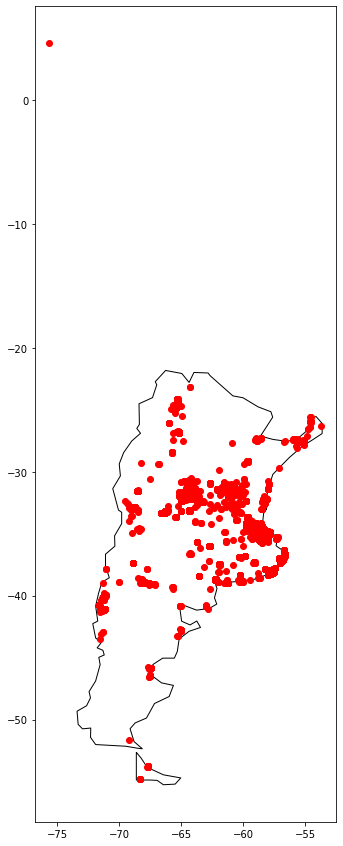

In [130]:
ax = argentina[argentina.name == 'Argentina'].plot(color='white', edgecolor='black', figsize = (10, 15))

geo_frame.plot(ax=ax, color='red')

plt.show()

Por el momento, no eliminamos el punto que se encuentra fuera de Argentina, debido a que un sólo datos mal georreferenciado no nos genera inconvenientes por el momento.
Como último paso, convertimos el GeoDataFrame a DataFrame para luego exportarlo como csv.

In [121]:
type(geo_frame)

geopandas.geodataframe.GeoDataFrame

In [136]:
final_frame = pd.DataFrame(geo_frame)
print(final_frame.shape)
type(final_frame)

(121220, 28)


pandas.core.frame.DataFrame

In [139]:
final_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121220 entries, 0 to 121219
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   Unnamed: 0                  121220 non-null  int64   
 1   operation                   121220 non-null  object  
 2   property_type               121220 non-null  object  
 3   place_name                  121197 non-null  object  
 4   place_with_parent_names     121220 non-null  object  
 5   country_name                121220 non-null  object  
 6   state_name                  121220 non-null  object  
 7   geonames_id                 102503 non-null  float64 
 8   lat-lon                     69670 non-null   object  
 9   lat                         69670 non-null   float64 
 10  lon                         69670 non-null   float64 
 11  price                       100810 non-null  float64 
 12  currency                    100809 non-null  object  
 13 

<a id="exportacion"></a> 
## Exportación de la base

[volver a TOC](#toc)
    
Como último paso, exportamos la base nueva. Los cambios realizados implican la recategorización de todas las propiedades de\
CABA en los 48 barrios oficiales, y la generación de la columna "geometry" con los datos georreferenciados para toda la base.

In [141]:
#final_frame.to_csv("final_frame.csv")